In [33]:
import pandas as pd
import sqlite3
import numpy as np

In [131]:
# assignmentID = 100
assignmentID = 139

query = f"""
select SubjectID, AssignmentID, CodeStateID, InterventionType, InterventionMessage, Contents from (
select SubjectID, AssignmentID, CodeStateID, InterventionType, InterventionMessage, CodeStateSection from MainTable where AssignmentId = "{assignmentID}" and InterventionCategory = "Feedback"
) as main JOIN CodeState where main.CodeStateID = CodeState.ID and main.CodeStateSection = CodeState.Filename
"""

con = sqlite3.connect("data/progsnap2_21_consenting_no_demographics.db")
df = pd.read_sql_query(query, con)

df["Correct"] = df.InterventionType == "complete|Complete"

df

,SubjectID,AssignmentID,CodeStateID,InterventionType,InterventionMessage,Contents,Correct
0,750,139,403848,algorithmic|Unused Variable,<p>The function <code class='pedal-name'>asser...,"b""from cisc108 import assert_equal\n\nnum_list...",False
1,750,139,403906,instructor|Student Unit Tests Failing,<p>2/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
2,750,139,403936,instructor|Student Unit Tests Failing,<p>1/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
3,750,139,403947,instructor|Student Unit Tests Failing,<p>3/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
4,750,139,403936,instructor|Student Unit Tests Failing,<p>1/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
...,...,...,...,...,...,...,...
1130,726,139,1021367,syntax|Syntax Error,<p>Bad syntax on line 22</p>\n<p>The traceback...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1131,726,139,1021368,algorithmic|Incorrect Arity,<p>The function <code class='pedal-name'>combi...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1132,726,139,1021369,algorithmic|Incorrect Arity,<p>The function <code class='pedal-name'>combi...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1133,726,139,1021370,algorithmic|Parameter Type Mismatch,<p>You defined the parameter <code class='peda...,"b""from cisc108 import assert_equal\n\ndef is_o...",False


In [132]:
np.mean(df.Correct)

0.13480176211453745

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
X = df.Contents
y = df.Correct

from sklearn.model_selection import train_test_split
X_train_code, X_test_code, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#vectorizer = TfidfVectorizer(lowercase=False, token_pattern="[\w]+|[^\s]|[ ]{4}")
vectorizer = CountVectorizer(lowercase=False, token_pattern="[\w]+|[^\s]|[ ]{4}", ngram_range=(1,3))
vectorizer.fit(X_train_code)
X_train = vectorizer.transform(X_train_code)
X_test = vectorizer.transform(X_test_code)

X_train.shape

(794, 5329)

In [134]:
feature_names = vectorizer.get_feature_names_out()
feature_names[0:50]

array(['    ', '         ', '              ', '          #',
       '          Args', '          Maximum_number', '          NUM',
       '          a', '          a_number', '          assert_equal',
       '          big', '          bool', '          break',
       '          continue', '          def', '          elif',
       '          else', '          first_odd_number', '          for',
       '          found', '          high', '          highOdd',
       '          higher', '          highest', '          highestodd',
       '          if', '          is_odd', '          item',
       '          largest', '          max', '          maxNum',
       '          maxOdd', '          max_num', '          max_number',
       '          max_odd', '          max_value', '          maxed',
       '          maxi', '          maxi_numb', '          maximum',
       '          maximum_number', '          maximum_odd',
       '          maximum_odd_number', '          maximum_odd_value'

In [135]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

np.mean(y_resampled)

0.5

In [136]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                        n_estimators=20, random_state=0).fit(X_resampled, y_resampled)

# clf = SVC().fit(X_resampled, y_resampled)



In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Training performance (without oversampling)
pred_train = clf.predict(X_train)

print(classification_report(y_train, pred_train))

confusion_matrix(y_train, pred_train)

              precision    recall  f1-score   support

       False       1.00      0.89      0.94       695
        True       0.57      1.00      0.73        99

    accuracy                           0.91       794
   macro avg       0.79      0.95      0.84       794
weighted avg       0.95      0.91      0.92       794



array([[621,  74],
       [  0,  99]], dtype=int64)

In [138]:
pred_test = clf.predict(X_test)

print(classification_report(y_test, pred_test))

confusion_matrix(y_test, pred_test)

              precision    recall  f1-score   support

       False       0.99      0.84      0.91       287
        True       0.53      0.94      0.68        54

    accuracy                           0.86       341
   macro avg       0.76      0.89      0.79       341
weighted avg       0.91      0.86      0.87       341



array([[241,  46],
       [  3,  51]], dtype=int64)

<AxesSubplot:ylabel='Count'>

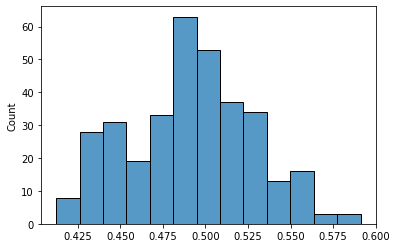

In [159]:
import seaborn as sns

probs = np.mean(np.array([est.predict_proba(X_test)[:,1] for est in clf.estimators_]), axis = 0)
sns.histplot(probs)

In [160]:
def unweighted_prediction(clf, X):
    preds = np.array([est.predict(X) for est in clf.estimators_])
    probs = np.mean(preds, axis = 0)
    pmax = np.max(probs)
    pmin = np.min(probs)
    return (probs - pmin) / (pmax - pmin)

sns.histplot(unweighted_prediction(clf, X_test))

array([0.22222222, 0.11111111, 0.66666667, 0.33333333, 0.55555556,
       0.88888889, 0.22222222, 0.44444444, 0.33333333, 0.22222222,
       0.11111111, 0.33333333, 0.22222222, 0.44444444, 0.22222222,
       0.22222222, 0.33333333, 0.11111111, 0.22222222, 0.33333333,
       0.33333333, 0.44444444, 0.33333333, 0.44444444, 0.55555556,
       0.33333333, 0.44444444, 0.77777778, 0.55555556, 0.11111111,
       0.33333333, 0.33333333, 0.44444444, 0.44444444, 0.66666667,
       1.        , 0.11111111, 0.22222222, 0.11111111, 0.44444444,
       0.44444444, 0.44444444, 0.11111111, 0.77777778, 0.66666667,
       0.66666667, 0.44444444, 0.        , 0.33333333, 0.44444444,
       0.55555556, 0.44444444, 0.55555556, 0.55555556, 0.22222222,
       0.33333333, 0.33333333, 0.22222222, 0.22222222, 0.22222222,
       0.55555556, 0.33333333, 0.55555556, 0.11111111, 0.        ,
       0.22222222, 0.22222222, 0.        , 0.22222222, 0.22222222,
       0.33333333, 0.55555556, 0.44444444, 0.55555556, 0.11111

In [161]:
sample = pd.DataFrame({
    'Code': X_test_code.str.decode('UTF-8'),
    'Progress_unweighted': unweighted_prediction(clf, X_test),
    'Progress_weigted': clf.predict_proba(X_test)[:,1],
    'Correct': y_test
})
sample.to_csv(f'data/out/p{assignmentID}.csv', index=False)
sample

,Code,Progress_unweighted,Progress_weigted,Correct
784,from cisc108 import assert_equal\n\ndef is_odd...,0.222222,0.460074,False
900,from cisc108 import assert_equal\n\ndef is_odd...,0.111111,0.131523,False
413,from cisc108 import assert_equal\n\ndef is_odd...,0.666667,0.563376,True
467,from cisc108 import assert_equal\n\ndef is_odd...,0.333333,0.501650,False
746,from cisc108 import assert_equal\n\ndef is_odd...,0.555556,0.551898,False
...,...,...,...,...
334,from cisc108 import assert_equal\n\ndef is_odd...,0.444444,0.516995,False
714,from cisc108 import assert_equal\n\ndef is_odd...,0.333333,0.504821,False
834,from cisc108 import assert_equal\n\ndef is_odd...,0.555556,0.190608,False
677,from cisc108 import assert_equal\n\ndef is_odd...,0.333333,0.145011,False


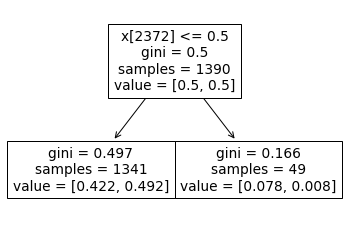

In [139]:
from sklearn.tree import plot_tree

def print_rule(clf, index):
    estimator = clf.estimators_[index]
#     name = feature_names[estimator.tree_.feature[0]]
#     thresh = estimator.tree_.threshold[0]
#     estimator_samples = clf.estimators_samples_[index]
#     children = estimator.apply(X_resampled[estimator_samples])
#     perc_child_1 = np.mean(y_resampled[estimator_samples][children == 1])
#     perc_child_2 = np.mean(y_resampled[estimator_samples][children == 2])
#     pred_child_1 = perc_child_1 > 0.5
#     pred_child_2 = perc_child_2 > 0.5
#     if pred_child_1 and pred_child_2:
#         print(f"Degenerate rule: always {pred_child_1}")
#         return
#     if pred_child_1:
#         print (f"If {name} < {thresh}, True")
#     else:
#         print (f"If {name} > {thresh}, True")
    plot_tree(estimator)
    
print_rule(clf, 8)

In [140]:
[feature_names[est.tree_.feature[0]] for est in clf.estimators_]

['is_odd (',
 'maximum_odd (',
 '10 ]',
 '6',
 '= 0     ',
 '2 , 7',
 'item ) =',
 'and',
 '= highest',
 ', 2 ,',
 ') >',
 '( number',
 ', 4 ,',
 '13',
 '[ 0 ]',
 '22 ) ,',
 '          return',
 '[ 2',
 ':      max_odd',
 '] )     ']